# **CNN** *Pytorch*

### **Imports...**

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import random_split
from sklearn.metrics import classification_report

### **GPU/MPS/CPU...**

In [4]:
if torch.cuda.is_available(): 
    device = "cuda"
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = "cpu"
print(
    f"~~~~~~~~~~~~~~~~~ \n"
    f"Using device: {device} \n"
    f"~~~~~~~~~~~~~~~~~")

~~~~~~~~~~~~~~~~~ 
Using device: mps 
~~~~~~~~~~~~~~~~~


### **CNN...**

In [5]:

class CNN(nn.Module):
    def __init__(self, in_channels, num_classes=26): 
       
        super(CNN, self).__init__()

        #1ST CONVOLUTIONAL LAYER
        self.conv1 = nn.Conv2d( 
            in_channels=in_channels,  
            out_channels=64, 
            kernel_size=3, 
            stride=1,  
            padding=1) 
        self.bn1 = nn.BatchNorm2d(64)
        
        #2ND CONVOLUTIONAL LAYER
        self.conv2 = nn.Conv2d(  
            in_channels=64,  
            out_channels=128, 
            kernel_size=3, 
            stride=1, 
            padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        #3RD CONVOLUTIONAL LAYER
        self.conv3 = nn.Conv2d(
            in_channels = 128,
            out_channels = 256,
            kernel_size = 3,
            stride = 1,
            padding = 1)
        self.bn3 = nn.BatchNorm2d(256)
        
        #POOLING LAYER
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #DROPOUT LAYER (FOR REGULARIZATION)
        self.drop_conv = nn.Dropout2d(p=0.2)
        self.drop_fc = nn.Dropout(p=0.5) 
        
        #FULLY CONNECTED LAYER
        self.adap = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) 
        x = self.pool(x) 
        x = self.drop_conv(x)          

        x = F.relu(self.bn2(self.conv2(x)))  
        x = self.pool(x)
        x = self.drop_conv(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.drop_conv(x)

        x = self.adap(x)
        x = x.view(x.size(0),-1)

        x = F.relu(self.fc1(x))
        x = self.drop_fc(x)       
        x = self.fc2(x)            

        return x

### **Hyperparamethers...**

In [6]:
num_classes = 26 
learning_rate = 0.005
batch_size = 200
num_epochs = 50
weight_decay = 0

### **Data loading, preprocessing and transforming...**

In [7]:
def emnist_rotation(img):
    img = img.rotate(-90, expand = True)
    img = img.transpose(Image.FLIP_TOP_BOTTOM)
    return img

def train_transform():
    return transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((32,32),antialias=True), 
    transforms.Lambda(emnist_rotation),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.1), shear = 3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307],std=[0.3081])])

def test_transform():
    return transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32,32),antialias=True),
    transforms.Lambda(emnist_rotation),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307],std=[0.3081])])

# ~~~~~~~~~~ SPLITTING THE TRAINING SET ~~~~~~~~~~~
train_base = datasets.EMNIST(root='emnist-letters-train', split='letters', train=True, download=True, transform=test_transform(), target_transform=lambda y: y-1)
train_set = int(0.8*len(train_base))
val_set = len(train_base)-train_set
train_dataset, val_dataset = random_split(train_base, [train_set,val_set])

# ~~~~~~~~~~ TRAIN ~~~~~~~~~~~
train_dataset.dataset.transform = train_transform()
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# ~~~~~~~~~~ VALIDATION ~~~~~~~~~~~
val_dataset.dataset.transform = test_transform()
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# ~~~~~~~~~~ TEST ~~~~~~~~~~~
test_dataset = datasets.EMNIST(root='emnist-letters-test', split='letters', train=False, download=True, transform=test_transform(), target_transform=lambda y: y-1)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### **Initialize network with loss and optimizer...**

In [8]:
model = CNN(in_channels=1, num_classes=num_classes).to(device)

In [9]:
criterion = nn.CrossEntropyLoss(label_smoothing= 0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

### **Train and evaluate...**

In [10]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # TRAINING 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0.0

    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        scores = model(data) # Forward
        loss = criterion(scores, targets)

        loss.backward() # Backward
        optimizer.step()

        batch_size = targets.size(0)
        train_loss += loss.item() * batch_size
        
        _, preds = scores.max(1)
        train_correct += (preds == targets).sum().item()
        train_total += batch_size
    
    train_loss /= train_total
    train_acc = 100.0 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # EVALUATION 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    model.eval()
    val_correct, val_total, val_loss = 0, 0, 0.0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            scores = model(x)
            
            loss = criterion(scores, y)
            batch_size = y.size(0)
            val_loss += loss.item() * batch_size

            _, predictions = scores.max(1) 
            val_correct += (predictions == y).sum().item() 
            val_total += batch_size

    val_loss /= val_total
    val_acc = float(val_correct) / float(val_total) * 100.0
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
        
    print(
        f" \n "
        f"|~|TRAINING:|~| Accuracy: {train_acc:.2f}, Loss: {train_loss:.4f}. \n "
        f"|~|EVALUATING:|~| Accuracy: {val_acc:.2f}, Loss: {val_loss:.4f}. \n " 
        f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~"
        )
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # SCHEDULER 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    scheduler.step()

    print()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# FINAL METRICS 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
final_train_loss = train_losses[-1]
final_train_acc = train_accuracies[-1]
final_val_loss = val_losses[-1]
final_val_acc = val_accuracies[-1]

print("===== Training Complete =====")
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Train Accuracy: {final_train_acc:.2f}%")
print(f"Final Test Loss: {final_val_loss:.4f}")
print(f"Final Test Accuracy: {final_val_acc:.2f}%")
    

Epoch [1/50]
Learning rate: 0.005000


100%|██████████| 500/500 [00:51<00:00,  9.78it/s]


 
 |~|TRAINING:|~| Accuracy: 57.55, Loss: 1.3304. 
 |~|EVALUATING:|~| Accuracy: 86.65, Loss: 0.4031. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [2/50]
Learning rate: 0.004995


100%|██████████| 500/500 [00:51<00:00,  9.80it/s]


 
 |~|TRAINING:|~| Accuracy: 82.94, Loss: 0.5292. 
 |~|EVALUATING:|~| Accuracy: 91.47, Loss: 0.2585. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [3/50]
Learning rate: 0.004980


100%|██████████| 500/500 [00:47<00:00, 10.63it/s]


 
 |~|TRAINING:|~| Accuracy: 87.23, Loss: 0.3944. 
 |~|EVALUATING:|~| Accuracy: 92.93, Loss: 0.2066. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [4/50]
Learning rate: 0.004956


100%|██████████| 500/500 [00:47<00:00, 10.58it/s]


 
 |~|TRAINING:|~| Accuracy: 89.14, Loss: 0.3398. 
 |~|EVALUATING:|~| Accuracy: 93.39, Loss: 0.1924. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [5/50]
Learning rate: 0.004921


100%|██████████| 500/500 [00:47<00:00, 10.55it/s]


 
 |~|TRAINING:|~| Accuracy: 90.18, Loss: 0.3087. 
 |~|EVALUATING:|~| Accuracy: 94.03, Loss: 0.1798. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [6/50]
Learning rate: 0.004878


100%|██████████| 500/500 [00:47<00:00, 10.54it/s]


 
 |~|TRAINING:|~| Accuracy: 90.80, Loss: 0.2858. 
 |~|EVALUATING:|~| Accuracy: 93.80, Loss: 0.1762. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [7/50]
Learning rate: 0.004824


100%|██████████| 500/500 [00:46<00:00, 10.80it/s]


 
 |~|TRAINING:|~| Accuracy: 91.21, Loss: 0.2676. 
 |~|EVALUATING:|~| Accuracy: 94.25, Loss: 0.1694. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [8/50]
Learning rate: 0.004762


100%|██████████| 500/500 [00:46<00:00, 10.77it/s]


 
 |~|TRAINING:|~| Accuracy: 91.81, Loss: 0.2529. 
 |~|EVALUATING:|~| Accuracy: 94.46, Loss: 0.1642. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [9/50]
Learning rate: 0.004691


100%|██████████| 500/500 [00:45<00:00, 10.94it/s]


 
 |~|TRAINING:|~| Accuracy: 91.96, Loss: 0.2424. 
 |~|EVALUATING:|~| Accuracy: 94.48, Loss: 0.1644. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [10/50]
Learning rate: 0.004611


100%|██████████| 500/500 [00:44<00:00, 11.18it/s]


 
 |~|TRAINING:|~| Accuracy: 92.28, Loss: 0.2334. 
 |~|EVALUATING:|~| Accuracy: 94.55, Loss: 0.1606. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [11/50]
Learning rate: 0.004523


100%|██████████| 500/500 [00:44<00:00, 11.21it/s]


 
 |~|TRAINING:|~| Accuracy: 92.53, Loss: 0.2260. 
 |~|EVALUATING:|~| Accuracy: 94.82, Loss: 0.1542. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [12/50]
Learning rate: 0.004426


100%|██████████| 500/500 [00:44<00:00, 11.20it/s]


 
 |~|TRAINING:|~| Accuracy: 92.59, Loss: 0.2187. 
 |~|EVALUATING:|~| Accuracy: 94.48, Loss: 0.1645. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [13/50]
Learning rate: 0.004322


100%|██████████| 500/500 [00:44<00:00, 11.16it/s]


 
 |~|TRAINING:|~| Accuracy: 92.89, Loss: 0.2126. 
 |~|EVALUATING:|~| Accuracy: 94.58, Loss: 0.1595. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [14/50]
Learning rate: 0.004211


100%|██████████| 500/500 [00:44<00:00, 11.17it/s]


 
 |~|TRAINING:|~| Accuracy: 93.05, Loss: 0.2038. 
 |~|EVALUATING:|~| Accuracy: 94.47, Loss: 0.1639. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [15/50]
Learning rate: 0.004094


100%|██████████| 500/500 [00:45<00:00, 11.02it/s]


 
 |~|TRAINING:|~| Accuracy: 93.24, Loss: 0.2003. 
 |~|EVALUATING:|~| Accuracy: 94.67, Loss: 0.1600. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [16/50]
Learning rate: 0.003969


100%|██████████| 500/500 [00:48<00:00, 10.40it/s]


 
 |~|TRAINING:|~| Accuracy: 93.43, Loss: 0.1933. 
 |~|EVALUATING:|~| Accuracy: 94.72, Loss: 0.1532. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [17/50]
Learning rate: 0.003840


100%|██████████| 500/500 [00:46<00:00, 10.64it/s]


 
 |~|TRAINING:|~| Accuracy: 93.49, Loss: 0.1904. 
 |~|EVALUATING:|~| Accuracy: 94.97, Loss: 0.1537. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [18/50]
Learning rate: 0.003704


100%|██████████| 500/500 [00:46<00:00, 10.75it/s]


 
 |~|TRAINING:|~| Accuracy: 93.74, Loss: 0.1842. 
 |~|EVALUATING:|~| Accuracy: 94.72, Loss: 0.1587. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [19/50]
Learning rate: 0.003564


100%|██████████| 500/500 [00:45<00:00, 11.02it/s]


 
 |~|TRAINING:|~| Accuracy: 93.90, Loss: 0.1779. 
 |~|EVALUATING:|~| Accuracy: 95.06, Loss: 0.1522. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [20/50]
Learning rate: 0.003420


100%|██████████| 500/500 [00:45<00:00, 10.94it/s]


 
 |~|TRAINING:|~| Accuracy: 93.90, Loss: 0.1772. 
 |~|EVALUATING:|~| Accuracy: 95.04, Loss: 0.1518. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [21/50]
Learning rate: 0.003273


100%|██████████| 500/500 [00:45<00:00, 10.95it/s]


 
 |~|TRAINING:|~| Accuracy: 94.14, Loss: 0.1688. 
 |~|EVALUATING:|~| Accuracy: 94.94, Loss: 0.1597. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [22/50]
Learning rate: 0.003122


100%|██████████| 500/500 [00:45<00:00, 10.90it/s]


 
 |~|TRAINING:|~| Accuracy: 94.21, Loss: 0.1654. 
 |~|EVALUATING:|~| Accuracy: 95.18, Loss: 0.1514. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [23/50]
Learning rate: 0.002968


100%|██████████| 500/500 [00:45<00:00, 11.01it/s]


 
 |~|TRAINING:|~| Accuracy: 94.39, Loss: 0.1611. 
 |~|EVALUATING:|~| Accuracy: 95.18, Loss: 0.1504. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [24/50]
Learning rate: 0.002813


100%|██████████| 500/500 [00:47<00:00, 10.57it/s]


 
 |~|TRAINING:|~| Accuracy: 94.55, Loss: 0.1562. 
 |~|EVALUATING:|~| Accuracy: 95.15, Loss: 0.1536. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [25/50]
Learning rate: 0.002657


100%|██████████| 500/500 [00:45<00:00, 10.99it/s]


 
 |~|TRAINING:|~| Accuracy: 94.68, Loss: 0.1502. 
 |~|EVALUATING:|~| Accuracy: 95.28, Loss: 0.1515. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [26/50]
Learning rate: 0.002500


100%|██████████| 500/500 [00:45<00:00, 11.03it/s]


 
 |~|TRAINING:|~| Accuracy: 94.81, Loss: 0.1481. 
 |~|EVALUATING:|~| Accuracy: 94.95, Loss: 0.1555. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [27/50]
Learning rate: 0.002343


100%|██████████| 500/500 [00:45<00:00, 11.04it/s]


 
 |~|TRAINING:|~| Accuracy: 94.94, Loss: 0.1433. 
 |~|EVALUATING:|~| Accuracy: 95.24, Loss: 0.1517. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [28/50]
Learning rate: 0.002187


100%|██████████| 500/500 [00:45<00:00, 11.06it/s]


 
 |~|TRAINING:|~| Accuracy: 94.90, Loss: 0.1432. 
 |~|EVALUATING:|~| Accuracy: 95.28, Loss: 0.1527. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [29/50]
Learning rate: 0.002032


100%|██████████| 500/500 [00:45<00:00, 11.06it/s]


 
 |~|TRAINING:|~| Accuracy: 95.11, Loss: 0.1382. 
 |~|EVALUATING:|~| Accuracy: 95.31, Loss: 0.1501. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [30/50]
Learning rate: 0.001878


100%|██████████| 500/500 [00:45<00:00, 10.98it/s]


 
 |~|TRAINING:|~| Accuracy: 95.18, Loss: 0.1354. 
 |~|EVALUATING:|~| Accuracy: 95.28, Loss: 0.1515. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [31/50]
Learning rate: 0.001727


100%|██████████| 500/500 [00:45<00:00, 11.01it/s]


 
 |~|TRAINING:|~| Accuracy: 95.18, Loss: 0.1329. 
 |~|EVALUATING:|~| Accuracy: 95.14, Loss: 0.1541. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [32/50]
Learning rate: 0.001580


100%|██████████| 500/500 [00:45<00:00, 10.97it/s]


 
 |~|TRAINING:|~| Accuracy: 95.31, Loss: 0.1307. 
 |~|EVALUATING:|~| Accuracy: 95.24, Loss: 0.1546. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [33/50]
Learning rate: 0.001436


100%|██████████| 500/500 [00:45<00:00, 10.99it/s]


 
 |~|TRAINING:|~| Accuracy: 95.34, Loss: 0.1280. 
 |~|EVALUATING:|~| Accuracy: 95.29, Loss: 0.1524. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [34/50]
Learning rate: 0.001296


100%|██████████| 500/500 [00:45<00:00, 11.02it/s]


 
 |~|TRAINING:|~| Accuracy: 95.43, Loss: 0.1245. 
 |~|EVALUATING:|~| Accuracy: 95.26, Loss: 0.1545. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [35/50]
Learning rate: 0.001160


100%|██████████| 500/500 [00:45<00:00, 11.03it/s]


 
 |~|TRAINING:|~| Accuracy: 95.51, Loss: 0.1212. 
 |~|EVALUATING:|~| Accuracy: 95.38, Loss: 0.1522. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [36/50]
Learning rate: 0.001031


100%|██████████| 500/500 [00:46<00:00, 10.65it/s]


 
 |~|TRAINING:|~| Accuracy: 95.54, Loss: 0.1204. 
 |~|EVALUATING:|~| Accuracy: 95.33, Loss: 0.1494. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [37/50]
Learning rate: 0.000906


100%|██████████| 500/500 [00:49<00:00, 10.03it/s]


 
 |~|TRAINING:|~| Accuracy: 95.69, Loss: 0.1183. 
 |~|EVALUATING:|~| Accuracy: 95.37, Loss: 0.1500. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [38/50]
Learning rate: 0.000789


100%|██████████| 500/500 [00:45<00:00, 10.91it/s]


 
 |~|TRAINING:|~| Accuracy: 95.69, Loss: 0.1160. 
 |~|EVALUATING:|~| Accuracy: 95.44, Loss: 0.1526. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [39/50]
Learning rate: 0.000678


100%|██████████| 500/500 [00:45<00:00, 11.07it/s]


 
 |~|TRAINING:|~| Accuracy: 95.83, Loss: 0.1145. 
 |~|EVALUATING:|~| Accuracy: 95.41, Loss: 0.1527. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [40/50]
Learning rate: 0.000574


100%|██████████| 500/500 [00:45<00:00, 10.96it/s]


 
 |~|TRAINING:|~| Accuracy: 95.84, Loss: 0.1114. 
 |~|EVALUATING:|~| Accuracy: 95.40, Loss: 0.1544. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [41/50]
Learning rate: 0.000477


100%|██████████| 500/500 [00:44<00:00, 11.18it/s]


 
 |~|TRAINING:|~| Accuracy: 95.88, Loss: 0.1106. 
 |~|EVALUATING:|~| Accuracy: 95.40, Loss: 0.1543. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [42/50]
Learning rate: 0.000389


100%|██████████| 500/500 [00:44<00:00, 11.17it/s]


 
 |~|TRAINING:|~| Accuracy: 95.96, Loss: 0.1096. 
 |~|EVALUATING:|~| Accuracy: 95.47, Loss: 0.1524. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [43/50]
Learning rate: 0.000309


100%|██████████| 500/500 [00:44<00:00, 11.17it/s]


 
 |~|TRAINING:|~| Accuracy: 95.92, Loss: 0.1092. 
 |~|EVALUATING:|~| Accuracy: 95.41, Loss: 0.1554. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [44/50]
Learning rate: 0.000238


100%|██████████| 500/500 [00:44<00:00, 11.19it/s]


 
 |~|TRAINING:|~| Accuracy: 95.92, Loss: 0.1087. 
 |~|EVALUATING:|~| Accuracy: 95.40, Loss: 0.1540. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [45/50]
Learning rate: 0.000176


100%|██████████| 500/500 [00:44<00:00, 11.18it/s]


 
 |~|TRAINING:|~| Accuracy: 95.99, Loss: 0.1084. 
 |~|EVALUATING:|~| Accuracy: 95.41, Loss: 0.1535. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [46/50]
Learning rate: 0.000122


100%|██████████| 500/500 [00:44<00:00, 11.20it/s]


 
 |~|TRAINING:|~| Accuracy: 96.02, Loss: 0.1059. 
 |~|EVALUATING:|~| Accuracy: 95.43, Loss: 0.1541. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [47/50]
Learning rate: 0.000079


100%|██████████| 500/500 [00:44<00:00, 11.15it/s]


 
 |~|TRAINING:|~| Accuracy: 96.05, Loss: 0.1059. 
 |~|EVALUATING:|~| Accuracy: 95.40, Loss: 0.1539. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [48/50]
Learning rate: 0.000044


100%|██████████| 500/500 [00:44<00:00, 11.21it/s]


 
 |~|TRAINING:|~| Accuracy: 96.05, Loss: 0.1045. 
 |~|EVALUATING:|~| Accuracy: 95.44, Loss: 0.1536. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [49/50]
Learning rate: 0.000020


100%|██████████| 500/500 [00:44<00:00, 11.17it/s]


 
 |~|TRAINING:|~| Accuracy: 96.08, Loss: 0.1051. 
 |~|EVALUATING:|~| Accuracy: 95.44, Loss: 0.1535. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch [50/50]
Learning rate: 0.000005


100%|██████████| 500/500 [00:44<00:00, 11.17it/s]


 
 |~|TRAINING:|~| Accuracy: 96.02, Loss: 0.1058. 
 |~|EVALUATING:|~| Accuracy: 95.42, Loss: 0.1539. 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

===== Training Complete =====
Final Train Loss: 0.1058
Final Train Accuracy: 96.02%
Final Test Loss: 0.1539
Final Test Accuracy: 95.42%


In [12]:
torch.save(model.state_dict(), "my_CNN.pth")

### **Plotting...**

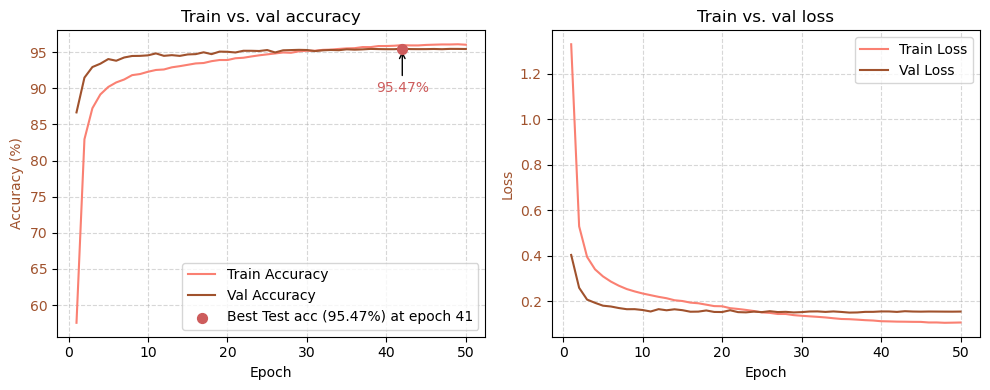

In [13]:
def plot_stats(train_acc, val_acc, train_loss, val_loss):
    epochs = range(1, len(train_acc)+1)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

    best_epoch = val_acc.index(max(val_acc))
    best_acc = val_acc[best_epoch]

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ACCURACY PLOT 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax1.plot(epochs, train_acc, label="Train Accuracy", color='salmon')
    ax1.plot(epochs, val_acc, label="Val Accuracy", color='sienna')

    ax1.scatter(best_epoch + 1, best_acc, color='indianred', s=50, zorder=5, label=f"Best Test acc ({best_acc:.2f}%) at epoch {best_epoch}")
    ax1.annotate(f'{best_acc:.2f}%',
                 xy=(best_epoch + 1, best_acc),
                 xytext=(best_epoch + 1, best_acc - 6),
                 ha='center', color='indianred',
                 arrowprops=dict(arrowstyle='->', color='black'))
    ax1.set_title('Train vs. val accuracy')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy (%)", color='Sienna')
    ax1.tick_params(axis='y', labelcolor='Sienna')
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.5)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # LOSS PLOT 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax2.plot(epochs, train_loss, label="Train Loss", color='salmon')
    ax2.plot(epochs, val_loss, label="Val Loss", color='sienna')
    ax2.set_title('Train vs. val loss')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss", color='sienna')
    ax2.tick_params(axis='y', labelcolor='sienna')
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle='--', alpha=0.5)

    plt.savefig("CNN_train_results_plot.png")
    plt.tight_layout()
    plt.show()

plot_stats(
    train_accuracies, 
    val_accuracies, 
    train_losses, 
    val_losses
)

### **Save results in file...**

In [14]:
results = "CNN_train_results.txt"
with open(results, "w") as f: 
    f.write("Epoch, Train loss, Train acc, Val loss, Val acc\n")
    for i in range(num_epochs):
        f.write(
            f"{i+1}, "
            f"{train_losses[i]:.4f}, "
            f"{train_accuracies[i]:.2f}%, "
            f"{val_losses[i]:.4f}, "
            f"{val_accuracies[i]:.2f}%\n")
        
    f.write("\n===== Final Metrics =====\n")
    f.write(f"Final Train Loss: {final_train_loss:.4f}\n")
    f.write(f"Final Train Accuracy: {final_train_acc:.2f}%\n")
    f.write(f"Final Val Loss: {final_val_loss:.4f}\n")
    f.write(f"Final Val Accuracy: {final_val_acc:.2f}%\n")

### **Testing the model...**

In [36]:
def accuracy(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for img, labl in dataloader:
            img, labl = img.to(device), labl.to(device)
            output = model(img)
            _, expected = torch.max(output, 1)
            total += labl.size(0)
            correct += (expected == labl).sum().item()
    accuracy = correct / total 
    return accuracy

def x_eval(model, dataloader, device):
    model.eval()
    all_predictions, all_labls = [], []
    with torch.no_grad():
        for img, labl in dataloader:
            img, labl = img.to(device), labl.to(device)
            output = model(img)
            _, predicted = torch.max(output, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labls.extend(labl.cpu().numpy())
    return classification_report(all_labls, all_predictions, digits=4)

def full_evaluation(model, dataloader, device):
    acc = accuracy(model, dataloader, device)
    class_rep = x_eval(model, dataloader, device)
    result_file = "CNN_test_result.txt"
    with open(result_file, "w") as f: 
        f.write(
            f"Test Accuracy: {acc} \n"
            f"Classification_report: {class_rep}")
    print(f" Test accuracy is: {acc:.4f}.")
    print(class_rep)

In [37]:
model.load_state_dict(torch.load("my_CNN.pth"))
model.to(device)
full_evaluation(model, test_loader, device=device)

 Test accuracy is: 0.9511.
              precision    recall  f1-score   support

           0     0.9434    0.9800    0.9614       800
           1     0.9898    0.9725    0.9811       800
           2     0.9716    0.9825    0.9770       800
           3     0.9721    0.9575    0.9647       800
           4     0.9764    0.9838    0.9801       800
           5     0.9873    0.9712    0.9792       800
           6     0.9254    0.8375    0.8793       800
           7     0.9673    0.9600    0.9636       800
           8     0.7518    0.7762    0.7638       800
           9     0.9744    0.9513    0.9627       800
          10     0.9912    0.9812    0.9862       800
          11     0.7610    0.7600    0.7605       800
          12     0.9913    0.9950    0.9931       800
          13     0.9616    0.9712    0.9664       800
          14     0.9597    0.9825    0.9710       800
          15     0.9888    0.9888    0.9888       800
          16     0.8752    0.9113    0.8928       800
